In [1]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [32]:

import nltk 
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import emoji
from emoji_extractor.extract import Extractor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vmoro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [17]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [18]:
dataset.head(6)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",0


## 2. Análisis exploratorio

In [23]:
text_list = dataset.tweet_text.to_list()
print(type(text_list))
print("Contamos con {} registros de tweets para la realización del analisis".format(len(text_list)))
print("La base de dato cuenta con {} columnas".format(dataset.shape[1]))

# Exploraremos la posible existencia de valores duplicados.

print(np.sum(dataset.duplicated(subset="tweet_text")))
dataset = dataset.drop_duplicates(subset="tweet_text")
np.sum(dataset.duplicated(subset="tweet_text"))
print("nos quedamos por tanto con {} registros únicos".format(len(dataset)))

#ahora vemos cuantos caracteres tiene cada registro creando una neuva variable

dataset["longitud"] = dataset["tweet_text"].apply(lambda x: len(x))
dataset.head(5)

<class 'list'>
Contamos con 46017 registros de tweets para la realización del analisis
La base de dato cuenta con 3 columnas
0
nos quedamos por tanto con 46017 registros únicos


,tweet_text,cyberbullying,longitud
0,"In other words #katandandre, your food was cra...",0,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103
4,@RudhoeEnglish This is an ISIS account pretend...,0,103


nos quedamos con 32292 registros


<Figure size 1600x1800 with 0 Axes>

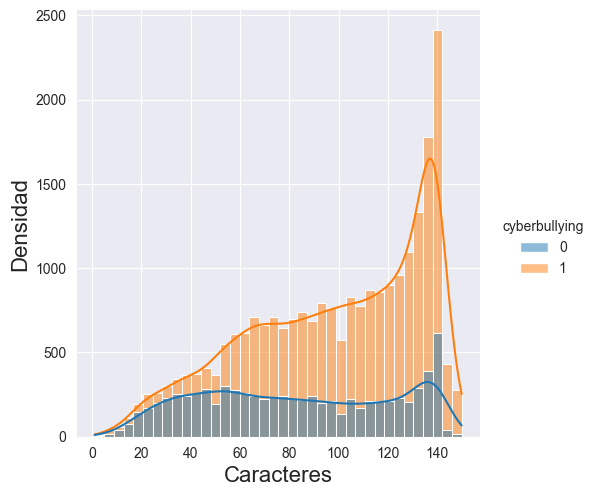

In [30]:
# ahora haremos un borrado de los tweets que tengan mas de 150 caracteres ya que tweeter tiene un maximo de 150 por tweet.
dataset = dataset.loc[dataset["longitud"]<=150]
print("nos quedamos con {} registros".format(dataset.shape[0]))
#graficaremos entonces, la longitud de los tweets y si estos tienen etiqueta de ciberbullying o no
fig = plt.figure(figsize=(16,18))
sns.set_style("darkgrid")
sns.displot(data=dataset, x="longitud", hue="cyberbullying", kde=True, legend=True)
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.show()

encontramos un patron en los tweets que si que estan etiquetados con bullying, siendo estos mas extensos que los que no lo contienen.

In [33]:
#generaremos entonces un wordcloud tanto para los tweets clasificados como bullying y los que no 
twt_0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list())
twt_1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list())

from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

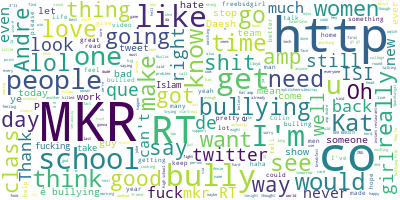

In [42]:
wordcloud.generate(twt_0)
wordcloud.to_image()

podemos destacar palabrascomo like, school, going women much... son palabras que combiandas pueden generar frases positivas

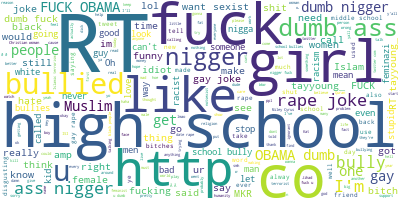

In [35]:
wordcloud.generate(twt_1)
wordcloud.to_image()

por otro lasdo los etiquetados como bullying aparecen con gran peso la palabra fuck, girl(posible discriminacion de genero), school (como abuso escolar), nigger (como comentario racista), RT (puede ser que los RT suelen generar mucho ''morbo'' a los ciberdelincuentes). 

In [36]:
#PASAREMOS ENTONCES A ANALIZAR LOS TWEETS QUE PUEDEN CONTENER EMOJIS.
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list
dataset["emojis"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))

con_emoji = dataset[dataset['emojis'].apply(lambda x: len(x) >= 1)]
sin_emoji = dataset[dataset['emojis'].apply(lambda x: len(x) ==0)]

# Imprimir el resultado
print("Número de tweets con emojis:", len(con_emoji))
print("Número de tweets sin emojis:", len(sin_emoji))

Número de tweets con emojis: 403
Número de tweets sin emojis: 31889


C:\Users\vmoro\AppData\Local\Temp\ipykernel_12212\3584649303.py:34: UserWarning: Glyph 10084 (\N{HEAVY BLACK HEART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\vmoro\AppData\Local\Temp\ipykernel_12212\3584649303.py:34: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\vmoro\AppData\Local\Temp\ipykernel_12212\3584649303.py:34: UserWarning: Glyph 128536 (\N{FACE THROWING A KISS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\vmoro\AppData\Local\Temp\ipykernel_12212\3584649303.py:34: UserWarning: Glyph 128563 (\N{FLUSHED FACE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\vmoro\AppData\Local\Temp\ipykernel_12212\3584649303.py:34: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\vmoro\AppData\Local\Temp\ipykernel_12212\3584649303.py:34: UserWarning: Glyph 128521 (\N{WINKING FACE}) missing from font(s) Arial.
  plt.tig

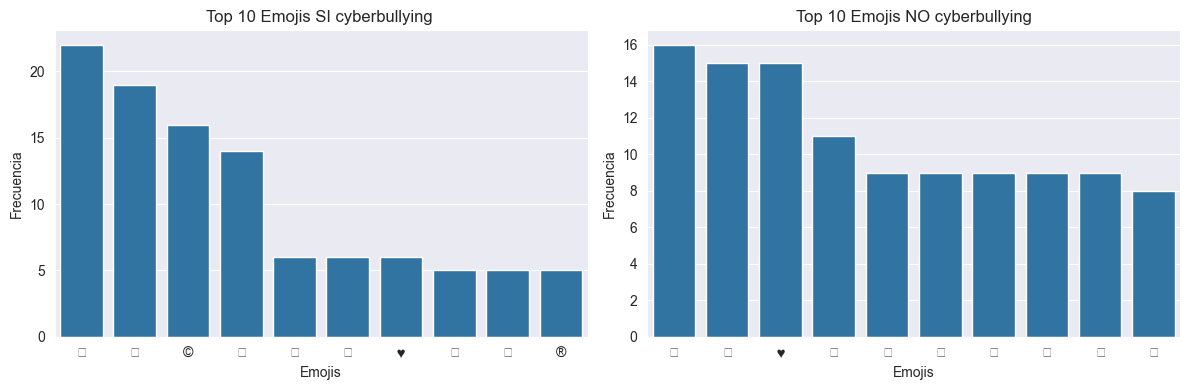

In [41]:
#¿cuantos de los tweets con emojis pueden ser una amenaza de bullyng y cuales no??
con_emoji_cyberbullying_0 = con_emoji[con_emoji['cyberbullying']==0].emojis.to_list()
con_emoji_cyberbullying_1= con_emoji[con_emoji['cyberbullying']==1].emojis.to_list()

con_emoji_cyberbullying_0 = [item for sublist in con_emoji_cyberbullying_0 for item in sublist]
con_emoji_cyberbullying_1 = [item for sublist in con_emoji_cyberbullying_1 for item in sublist]

#vamos a graficar los emoticonos que aparecen con mas frecuencia cuando hay bullyng y cuando no.

from collections import Counter
from matplotlib import font_manager

# Genero una variable que me cuenta las veces que aparece cada emoji
freq_icono_y_cyberbullying_1 = Counter(con_emoji_cyberbullying_1)
freq_icono_y_cyberbullying_0 = Counter(con_emoji_cyberbullying_0)

# Le pido que me ordene los emojis en función de las veces que aparecen de mauor a menor
emojis1, frecuencias_elementos1 = zip(*sorted(freq_icono_y_cyberbullying_1.items(), key=lambda x: x[1], reverse=True)[:10])
emojis0, frecuencias_elementos0 = zip(*sorted(freq_icono_y_cyberbullying_0.items(), key=lambda x: x[1], reverse=True)[:10])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Genero el gráfico con los emojis de los tweets considerados cyberbullying
sns.barplot(x=emojis1, y=frecuencias_elementos1, ax=axes[0])
axes[0].set_xlabel('Emojis')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Top 10 Emojis SI cyberbullying ')

# Genero el gráfico con los emojis de los tweets NO considerados cyberbullying
sns.barplot(x=emojis0, y=frecuencias_elementos0, ax=axes[1])
axes[1].set_xlabel('Emojis')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Top 10 Emojis NO cyberbullying')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la imagen
plt.show()

conclusiones analisis exploraotorio emojis: Dentro de los tweets que contienen emojis y estan etiquetados como bullying, cabe destacar que el emoji mas frecunte es un corazon, podriamos explicar con el wordmap que una de las palabras mas usadas es like, como deseo de un mal ajeno. Con respecto a los tweets con emoji y etiquetados como no bullying, tenemos caras sonrientes, bailes corazones....

## 3. Preprocesado y Normalización

In [45]:
# NORMALIZAREMOS LOS DATOS A TRAVES DE FUNCIONES VISTAS DURANTE LAS CLASES

#mediante las dos siguientes dunciones conseguiremos eliminar los espacios 
# y convertir las mayusculas en minusculas.
def eliminar_espacios(texto):
    return " ".join(texto.split())

def texto_a_minusculas(texto):
    return texto.lower()

# ahora aplicamos las funciones sobre nuestro dataset, aunque generaremos una columna nueva para no modificar el conjunto de datos original

dataset["normalizado"] = dataset["tweet_text"].apply(lambda x: eliminar_espacios(x)) 
dataset["normalizado"] = dataset["normalizado"].apply(lambda x: texto_a_minusculas(x))

#haremos tambien uso de una funcion aprendida en clase para reemplazar ciertas expresiones en inglés
import contractions
def reemplazar_contracciones(text):
    return contractions.fix(text, slang= True)

dataset["normalizado"] = dataset["normalizado"].apply(lambda x: reemplazar_contracciones(x))

In [46]:
# a continuacion tokenizaremos diferentes caracteres o cadenas de estos que en twitter siginifacn diversas cosas. Como por ejemplo @ = mencion, http = URL, digito = num
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(ds):
    palabras = tweet_tokenizer.tokenize(ds)
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    documento_modificado = " ".join(palabras)
    return documento_modificado

# una vez creada la funcion la pasaremos por el dataset de nuevo.
dataset["normalizado"] = dataset["normalizado"].apply(lambda x: normalizar_tokens(x))

In [49]:
#  ELIMINAMOS PUNTOS DE PUNTUACION Y ADEMAS LAS PALABRAS QUE NO APORTAM INFO = STOPWORDS
#  LEMATIZACION A LAS RAICES DE LAS PALABRAS, DE MANERA QUE REDUCIREMOS AL SIGNIFICADO BASE DE CADA PALABRA, AUMENTANDO LA PRECISION DEL ANALISIS
import spacy

nlp = spacy.load("en_core_web_sm", disable = ["parser","ner"])

def lematizar_eliminacion_tokens(texto):
    doc = nlp(texto)
    # Lematización del texto
    lemas = [token.lemma_ for token in doc]
    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]
    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)
    return texto_procesado

In [51]:
dataset["texto_procesado"] = dataset["normalizado"].apply(lambda x: lematizar_eliminacion_tokens(x))

In [56]:
# ANALISIS DE LOS SENTIMIENTOS EN LOS TWEETS PROCESADOS. Para ello usaremos una funcion vista en clase
def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e:
      continue

  if len(lista)>=1:
    longitud = len(lista)
  else:
    longitud =1
  return output/ longitud

# sobre el dataset generaremos tres nuevas columnas donde incluiremos el numero de emojis segun si el sentimiento es negativo positivo o neutro

dataset["sent_emoji_pos"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "positive"))
dataset["sent_emoji_neu"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
dataset["sent_emoji_neg"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "negative"))

# definiremos otra funcion en la que haremos lo mimso que en la anterior pero con las palabras claves tokenizadas descritas en unas celdas mas arriba
def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

dataset["num_mention"] = dataset["texto_procesado"].apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["texto_procesado"].apply(lambda x: token_appearance(x, token="URL"))
dataset["num_NUM"] = dataset["texto_procesado"].apply(lambda x: token_appearance(x, token="NUM"))

A continuación, voy a realizar el análisis de sentimiento de los textos que forman los tweets.
Este análisis de sentiemiento lo voy a realizar calculando dos vairables:
- Objetividad: indican cuánto de objetivo o subjetivo es el texto, es una escala entre 0 y 1 donde 0 valores ceracanos a 0 son subjetivos y cercanos a 1 objetivos.
- Polaridad: escala entre -1 y 1 que tratan el sentimiento del texto, siendo -1 un sentimiento negativo y 1 un sentimiento positivo.



In [60]:
from textblob import TextBlob
dataset["tweet_sentiment_polarity"] = dataset["texto_procesado"].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset["tweet_sentiment_subjectivity"] = dataset["texto_procesado"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

## 4. Vectorización

In [61]:
#para poder incluir los tweets en modelos de clasificación se utilizan las tecnicas de vectorización por lo que haremos una serie de tranformaciones mediante los metodos de la libleria sklearn

from sklearn.feature_extraction.text import TfidfVectorizer

vecotrizador = TfidfVectorizer(lowercase=False, stop_words= None, min_df=0.005, ngram_range=(1,3))

# para asignar pesos a las palabras que componen los tweets se utilizará el método TF-IDF
data_vector = vecotrizador.fit_transform(dataset["texto_procesado"])

#este metodo generados una serie de variables nuevas, vamos a unirlas al dataset para incluirlas al modelo posteriormente
extra_features = dataset[['num_mention','num_URLS','num_NUM','tweet_sentiment_subjectivity','tweet_sentiment_polarity','sent_emoji_pos','sent_emoji_neg','sent_emoji_neu']]

# y unimos el vector generado con las variables, y= etiquetas, x= variables a traves de las cuales trataremos de predecir

import scipy as sp

y = dataset["cyberbullying"].values.astype(np.float32)
x = sp.sparse.hstack((data_vector, extra_features.values),format='csr')

columnas_x = list(vecotrizador.get_feature_names_out()) + extra_features.columns.tolist()

## 5. Entrenamiento y evaluación de modelos


In [63]:
# se utiliza una funcion conocida del master para comparar varios modelos, para ver cual nos da mejor resultado con los datos procesados que hemos obtenido

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

def evaluacion_modelos(models, score, X, y):
      results = []
      names = []

      for name, model in models:
          warnings.filterwarnings('ignore')

          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)


          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)


          results.append(cv_results)
          names.append(name)


          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [65]:
# utilizaremos la funcion para comparar un modelo de regresión logística, naves bayes y un arbol de decisión
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ('DecisionTree',DecisionTreeClassifier())
]

evaluation_score = "accuracy"

evaluacion_modelos(models,  evaluation_score, data_vector.toarray(), y)


Metric: accuracy , KFold 
Logistic: 0.800973 (0.004623) 
Metric: accuracy , KFold 
GaussianNB: 0.596340 (0.003940) 
Metric: accuracy , KFold 
DecisionTree: 0.791775 (0.004019) 


([array([0.79594364, 0.79981421, 0.80318984, 0.79715082, 0.80876432]),
  array([0.59188729, 0.59297105, 0.60297306, 0.59600496, 0.59786312]),
  array([0.79052485, 0.79191825, 0.79854444, 0.78600186, 0.79188603])],
 ['Logistic', 'GaussianNB', 'DecisionTree'])

In [69]:
# con los datos obtenidos podemoss ver que segun la precisión, el mejor modelo seria el de una regresión, por lo que utilizaremos el siquiuente modelo
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV #con el siguiente metodo decidiremos entre los siguientes parametros cual es la mejor combinación de estos
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y , random_state=0,
                                                    stratify = y)

grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros del GridSearch CV %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.800198 usando los parámetros del GridSearch CV {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [71]:
# una vez seleccionados los parametros mejores, haremos un entrenamiento del modelo con estos parametros incluidos
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=1, penalty="l2", solver = "newton-cg")
model.fit(X_train,y_train)

#una vez el modelo ahremos el test sobre el subconjunto xtest y mostraremos sus resultados por pantalla
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 799 1183]
 [ 375 5716]]
              precision    recall  f1-score   support

         0.0       0.68      0.40      0.51      1982
         1.0       0.83      0.94      0.88      6091

    accuracy                           0.81      8073
   macro avg       0.75      0.67      0.69      8073
weighted avg       0.79      0.81      0.79      8073



La conclusión basada en estos resultados sugiere que el modelo de regresión lineal, al aplicarse sobre un conjunto de datos binarios (donde las clases son 0.0 y 1.0), tiene un desempeño moderado con los siguientes puntos destacados:

-Matriz de confusión:

Clase 0.0 (negativa): El modelo predijo correctamente 818 casos, pero falló en 1164 (falsos positivos, donde predijo 1.0 cuando la clase real era 0.0).
Clase 1.0 (positiva): El modelo predijo correctamente 5678 casos, pero cometió 396 errores (falsos negativos, donde predijo 0.0 cuando la clase real era 1.0).

-Precisión :

Para la clase 0.0 es del 67%, lo que indica que, de todas las veces que el modelo predijo 0.0, el 67% fueron correctas.
Para la clase 1.0 es del 83%, es decir, cuando predice 1.0, es correcta el 83% del tiempo.
Exhaustividad (recall):

Para la clase 0.0 es del 41%, lo que indica que solo logra capturar correctamente el 41% de los casos totales que realmente eran 0.0.
Para la clase 1.0 es del 93%, lo que indica que el modelo tiene una alta capacidad para capturar la mayoría de los casos reales de la clase 1.0.

-F1-score:

Para la clase 0.0 es 0.51, lo que indica un equilibrio bajo entre precisión y recall para esta clase.
Para la clase 1.0 es 0.88, lo que muestra un buen equilibrio entre precisión y recall para esta clase.

-Accurancy total:

El modelo tiene una precisión del 81%, lo que significa que predijo correctamente el 81% de las muestras totales.

-Promedios (macro avg y weighted avg):

El macro promedio indica que, en promedio, el rendimiento entre ambas clases es moderado, con un valor de 0.67 en recall y 0.70 en F1-score.
El promedio ponderado (weighted avg) da más peso a la clase mayoritaria (1.0), con valores cercanos a 0.79 y 0.81, lo que sugiere que el modelo se desempeña mejor para la clase 1.0.

-Conclusión:

El modelo de regresión lineal tiene un buen desempeño al identificar la clase mayoritaria (1.0), con alta precisión y recall, pero su rendimiento para la clase minoritaria (0.0) es relativamente bajo, especialmente en términos de recall (41%). El modelo tiende a clasificar mejor los casos de la clase 1.0, probablemente porque hay más datos de esta clase. Aunque el rendimiento global es aceptable (81% de exactitud), podría mejorarse el desempeño sobre la clase 0.0, quizás con técnicas de balanceo de clases o ajustes en el modelo.